In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [3]:
data=10000
batch=100
set=100
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.01
c_reg2=0.0001
d=3

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.383226903562752>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.42182940879486>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.3106280886846441>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.1681353232528403>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([ 1.8932716 ,  2.08904581,  3.25422679, -0.92949274,  0.68242529,
        0.79851152,  2.34871383,  1.1097625 ,  1.64495101,  0.2189682 ])>


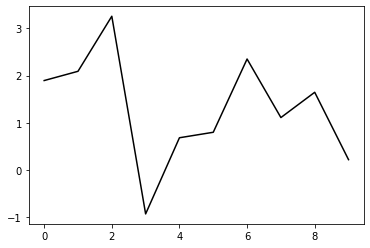

In [25]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.2 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
y[:]=[2*v for v in y]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 1.59046394e-05 -6.81729682e-04  1.31412795e-02 -1.50525136e-01
  1.14052774e+00 -6.02241647e+00  2.27455168e+01 -6.20704699e+01
  1.22166922e+02 -1.71187074e+02  1.66428955e+02 -1.07461552e+02
  4.28229887e+01 -9.20544914e+00  9.55260239e-01 -1.30911492e-04]


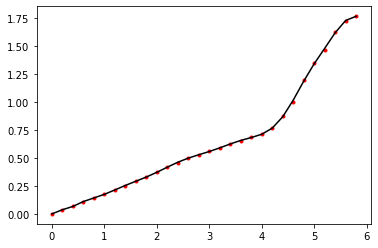

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.2) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

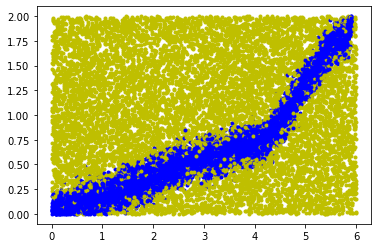

In [10]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [11]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [12]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [22]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

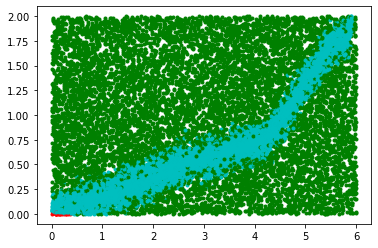

In [23]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [15]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)/batch
    sum_n=(batch-sum(NNlist))/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [16]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(1.0813405033643786, shape=(), dtype=float64)
tf.Tensor(1.0413408787860294, shape=(), dtype=float64)
tf.Tensor(1.0514893198543427, shape=(), dtype=float64)
tf.Tensor(1.0726422860262104, shape=(), dtype=float64)
tf.Tensor(1.041733405216531, shape=(), dtype=float64)
tf.Tensor(1.0613030636273355, shape=(), dtype=float64)
tf.Tensor(1.0813192218256162, shape=(), dtype=float64)
tf.Tensor(1.0513949401238931, shape=(), dtype=float64)
tf.Tensor(1.1180356872285082, shape=(), dtype=float64)
tf.Tensor(1.0514000048215544, shape=(), dtype=float64)
tf.Tensor(1.0903336737371245, shape=(), dtype=float64)
tf.Tensor(1.0607980087201647, shape=(), dtype=float64)
tf.Tensor(1.0713376697470602, shape=(), dtype=float64)
tf.Tensor(1.0603904256848642, shape=(), dtype=float64)
tf.Tensor(1.0724144474120836, shape=(), dtype=float64)
tf.Tensor(1.0713972856565372, shape=(), dtype=float64)
tf.Tensor(1.0545792964544674, shape=(), dtype=float64)
tf.Tensor(1.0575796200970244, shape=(), dtype=float64)
tf.Tensor(1

# Optimize

0 1.0495023118484426
0.051758360484816114 0.11004862947998674 -0.34294067866460587 0.28202921172661816
[0.91180979 2.64767742 2.62198433 1.23410559 2.58959538 1.84191629
 0.88606782 0.7175601  2.30213999 2.54529284]


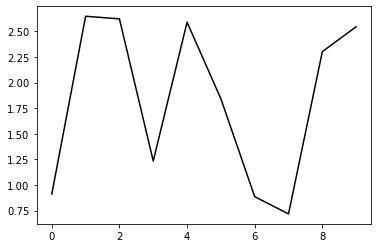

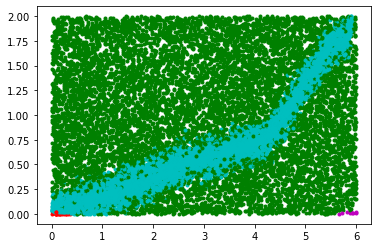

1000 0.36459413402252594
-0.09473305208188045 0.10788958117757094 -0.17838738690793388 0.05500545721282429
[ 1.26635398  1.39017772  1.41216746  1.31016971  1.15630001  0.83802395
  0.22238767 -0.25405802  0.86950728  7.00299361]


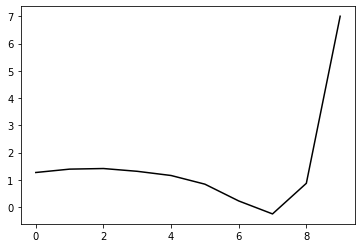

2000 0.1770460862268786
-0.07577430600841292 0.20705483914314682 -0.23417495599579913 0.05858167936220587
[ 1.47400247  1.20345173  0.99895079  0.87520724  0.78995877  0.63456738
  0.26270253 -0.1353298   0.92545126  8.74996737]


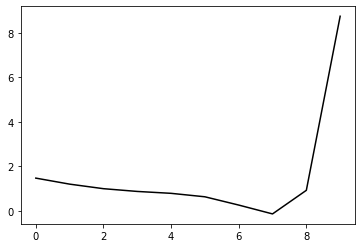

3000 0.16982743140160772
-0.07193499048778454 0.21802993082940805 -0.24571844224204076 0.05893789232099918
[ 1.52701928  1.28155101  1.00457395  0.74341278  0.51834624  0.2878638
 -0.07057319 -0.48845683  0.43456203  8.65784102]


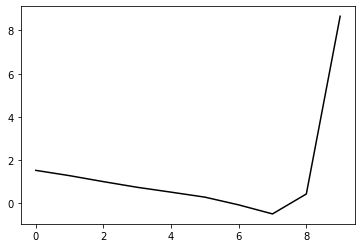

4000 0.18126770164371522
-0.06618498516045655 0.2221926289341458 -0.25064668891020464 0.06259310809728866
[ 1.561734    1.36792959  1.11817255  0.83542824  0.53848394  0.22393797
 -0.17078871 -0.61942994  0.16245967  8.63508352]


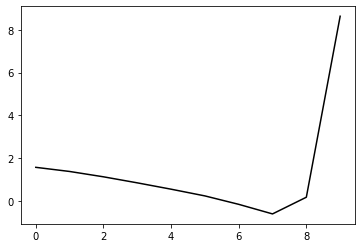

5000 0.21201036780080046
-0.06352247083341497 0.22272343892716656 -0.253148079408523 0.0631725105325154
[ 1.57801082  1.41108729  1.20713048  0.95105013  0.63336103  0.25176045
 -0.20447231 -0.69210771 -0.05005369  8.62494862]


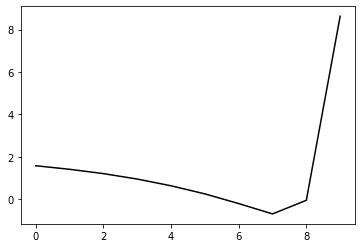

6000 0.22585380955510515
-0.06494065531318603 0.2233757310751325 -0.25546856234375087 0.06601927762576942
[ 1.59646885  1.48804717  1.28430568  1.02803455  0.6996482   0.27769382
 -0.24135498 -0.78605899 -0.27547802  8.5890581 ]


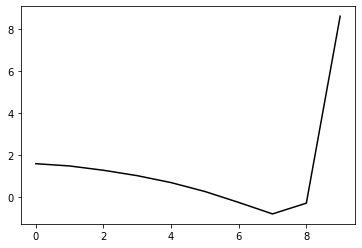

7000 0.2937020508264362
-0.061819944550601004 0.22506753728803627 -0.2587264221185876 0.06814794129449828
[ 1.61903803  1.45945486  1.26914598  1.02222214  0.6885259   0.2407359
 -0.32966716 -0.93445827 -0.54221753  8.5352389 ]


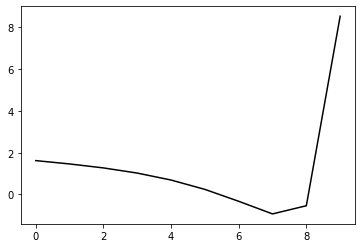

8000 0.23230362658740725
-0.061722558141948165 0.22508499496683113 -0.26140646706592374 0.06521427420394485
[ 1.5921476   1.44721734  1.27084767  1.02736476  0.69200728  0.23028656
 -0.38342012 -1.06285485 -0.81219863  8.49096228]


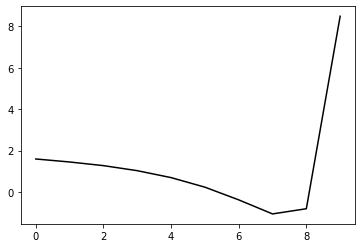

9000 0.238260173134857
-0.060643598586498475 0.2250738838206328 -0.2628243364536327 0.0706181213581689
[ 1.6388777   1.49688489  1.32844753  1.08738447  0.75205881  0.28075314
 -0.36661516 -1.11851293 -1.01158535  8.48072566]


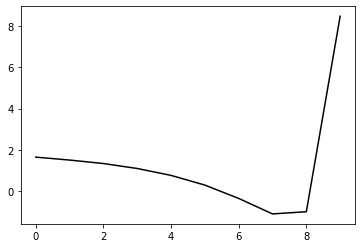

10000 0.25225573511497096
-0.05868545737263755 0.22191836323886124 -0.2623052148988735 0.07108955387493636
[ 1.65202684  1.46763073  1.29241337  1.0536415   0.71325503  0.22498207
 -0.45847785 -1.27865182 -1.29176819  8.47729013]


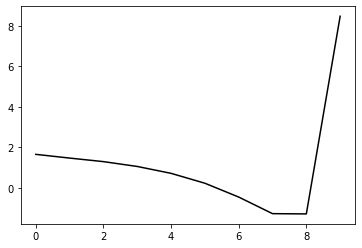

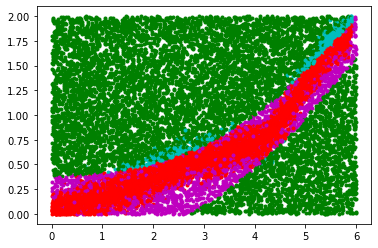

11000 0.2648547806349613
-0.06328076110016065 0.22585546111668972 -0.2679859752251687 0.0705239677363743
[ 1.57075997  1.46338684  1.32599482  1.11459986  0.79465606  0.31878808
 -0.36938522 -1.22744127 -1.33140297  8.4640927 ]


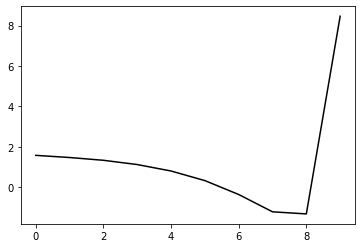

12000 0.2176411925217772
-0.06559562867055893 0.2272446287706318 -0.2719831500257049 0.06868861098752027
[ 1.61360266  1.41065425  1.23079414  1.00611157  0.67948448  0.1862354
 -0.54122434 -1.47385437 -1.69168407  8.3740995 ]


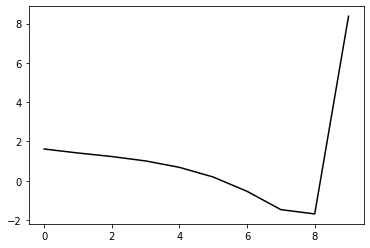

13000 0.25099047661304924
-0.0624545748157645 0.22647562339310612 -0.2729693647379674 0.07210599985818367
[ 1.59387185  1.47307234  1.32588428  1.1176465   0.80530846  0.32775477
 -0.39462865 -1.3545199  -1.64390273  8.431176  ]


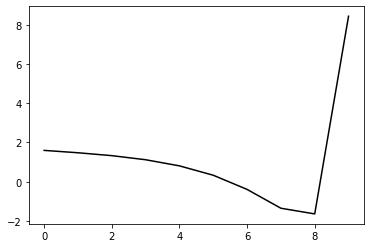

14000 0.282514728692161
-0.05767727314354808 0.22152592606153887 -0.27072642729625207 0.07719960468310438
[ 1.67633517  1.49327464  1.33207073  1.11338334  0.79121898  0.30216948
 -0.44354361 -1.46291873 -1.87475176  8.34037981]


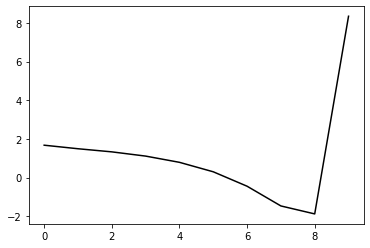

15000 0.2284253877670007
-0.06391931136433782 0.22794539121854832 -0.2788417145042663 0.07485702362081698
[ 1.61262216  1.51520735  1.36290321  1.14671289  0.83158049  0.35331151
 -0.38558741 -1.42226287 -1.89795822  8.35442754]


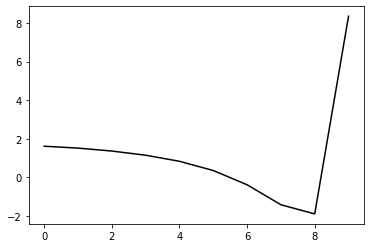

16000 0.1430967201316958
-0.05765653465985472 0.22403698846804712 -0.2783001545162633 0.07445080017645284
[ 1.68012112  1.54381769  1.37907403  1.16571642  0.8546828   0.37460825
 -0.3747031  -1.45077132 -2.02698977  8.35284706]


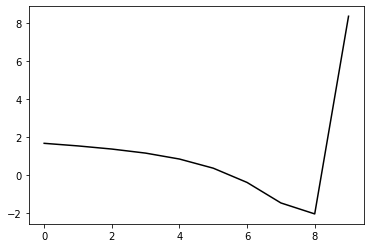

17000 0.2054598774308959
-0.05776713789532169 0.22347840960874238 -0.279696156946731 0.0755729653330565
[ 1.60355989  1.48187435  1.35490862  1.1619141   0.85821432  0.38009313
 -0.37111113 -1.46496191 -2.09813071  8.31559402]


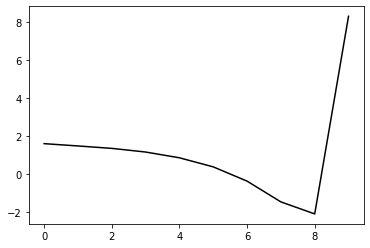

18000 0.18500515533885312
-0.05744489875365655 0.22430620903610402 -0.28247587721170675 0.0769529225175132
[ 1.65780129  1.57149428  1.42355316  1.20656258  0.89096104  0.40175118
 -0.3756717  -1.52667945 -2.27916554  8.31096721]


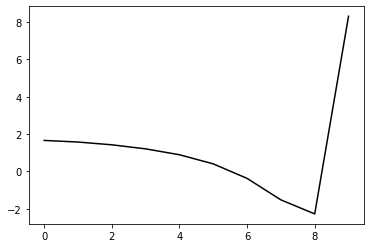

19000 0.16535358111784246
-0.05718667091724307 0.22204841988044652 -0.2828123730080612 0.07653070961270163
[ 1.6140477   1.49903152  1.36768337  1.16880466  0.85731848  0.36437926
 -0.4227217  -1.60534121 -2.44284504  8.30724508]


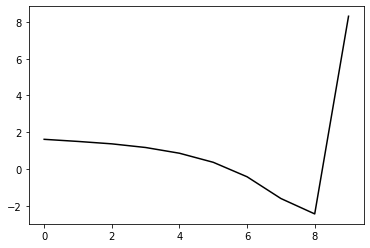

20000 0.17840355670288988
-0.055903285526801114 0.22038109393342226 -0.2844027661184546 0.07507288196924745
[ 1.62863904  1.51101645  1.37580055  1.18551371  0.89100852  0.41291802
 -0.367818   -1.56565674 -2.47379058  8.28566048]


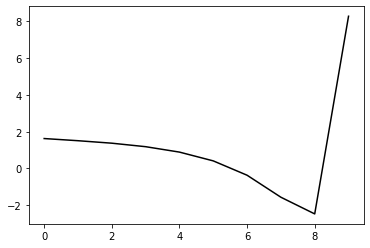

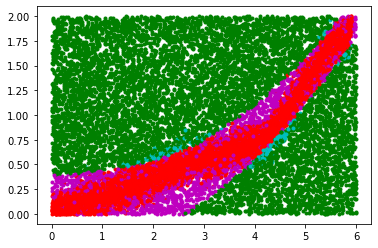

21000 0.24698579690808825
-0.05658119119313027 0.2200511149921773 -0.28643208195191144 0.07464721234065977
[ 1.59289821  1.49863793  1.37729158  1.1926383   0.90464634  0.43918373
 -0.33067641 -1.53557431 -2.49933516  8.25790507]


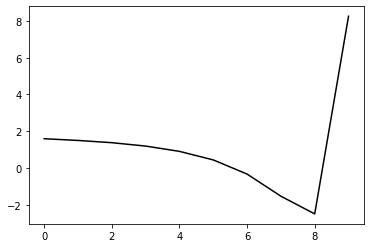

KeyboardInterrupt: 

In [24]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

In [ ]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

In [ ]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

In [ ]:
print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
plt.plot(h.numpy(), 'k-'), plt.show()